In [107]:
import sys
sys.path.insert(0,'/home/emmanuel/Drives/erc/code/gp_autograd')
sys.path.insert(0,'/Users/eman/Documents/code_projects/gp_autograd')

# Import Kernellib 

import numpy as np
from gp_autograd.gaussianprocess import GaussianProcess, sample_data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, WhiteKernel, ConstantKernel as C)

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
!pwd

/Users/eman/Documents/code_projects/gp_autograd/notebooks


### Sample Data

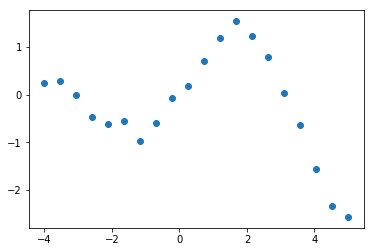

In [109]:
xtrain, xtest, ytrain, ytest = sample_data()

# Plot
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain)

plt.show()


## Fit GP Model

In [110]:
# Initialize GP Model
mygp_model = GaussianProcess()

mygp_model.fit(xtrain, ytrain);


kernel = C() * RBF() + WhiteKernel()
skgp_model = GaussianProcessRegressor(kernel=kernel, random_state=123)

skgp_model.fit(xtrain, ytrain);

In [111]:
print(mygp_model.signal_variance)
print(mygp_model.length_scale)
print(mygp_model.noise_likelihood)


print(skgp_model.kernel_.get_params()['k1__k1__constant_value'])
print(skgp_model.kernel_.get_params()['k1__k2__length_scale'])
print(skgp_model.kernel_.get_params()['k2__noise_level'])


2.68734029804
[ 2.10342245]
0.01632140762
2.68734336839
2.10342319428
0.0163214032144


In [112]:
from scipy.spatial.distance import cdist

In [113]:
skdist = cdist(xtest / skgp_model.kernel_.get_params()['k1__k2__length_scale'],skgp_model.X_train_ / skgp_model.kernel_.get_params()['k1__k2__length_scale'],
                          metric='sqeuclidean')
mydist = np.expand_dims(xtest / mygp_model.length_scale, 1) \
    - np.expand_dims(mygp_model.X_train_ / mygp_model.length_scale, 0)
mydist = np.sum(mydist ** 2, axis=2)
np.testing.assert_array_almost_equal(skdist, mydist, decimal=5)

In [114]:
mK_traintest = mygp_model.rbf_covariance(xtest, mygp_model.X_train_, 
                                        mygp_model.signal_variance, 
                                        mygp_model.length_scale)
sK_traintest = skgp_model.kernel_(xtest, skgp_model.X_train_)

np.testing.assert_array_almost_equal(mK_traintest, sK_traintest, decimal=4)

### Predictions and Variance

#### Autograd GP

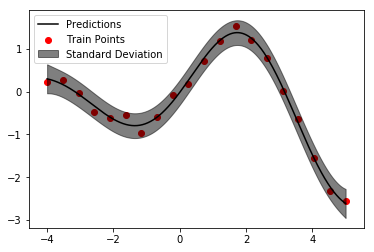

In [105]:


# Plot results
fig, ax = plt.subplots()

upper_limit = y_pred.squeeze() + 2*y_std.squeeze()
lower_limit = y_pred.squeeze() - 2*y_std.squeeze()




ax.plot(xtest, y_pred, color='black', label='Predictions')
ax.scatter(xtrain, ytrain, color='red', label='Train Points')
ax.fill_between(xtest.squeeze(), upper_limit, lower_limit,
                color='k', alpha=0.5, label='Standard Deviation')

ax.legend()
plt.show()


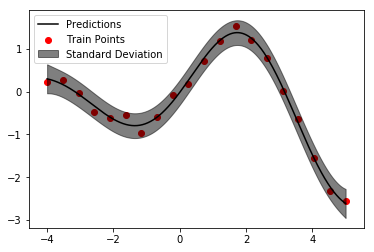

In [106]:
# Get predictions
y_pred, y_std = skgp_model.predict(xtest, return_std=True)

# Plot results
fig, ax = plt.subplots()

upper_limit = y_pred.squeeze() + 2*y_std.squeeze()
lower_limit = y_pred.squeeze() - 2*y_std.squeeze()




ax.plot(xtest, y_pred, color='black', label='Predictions')
ax.scatter(xtrain, ytrain, color='red', label='Train Points')
ax.fill_between(xtest.squeeze(), upper_limit, lower_limit,
                color='k', alpha=0.5, label='Standard Deviation')

ax.legend()
plt.show()

### 1st Derivative


#### Numerical

In [69]:
d1_numerical = gp_model.mu_grad(xtest)          # 1st Derivative


#### Analytical

In [70]:
weights = gp_model.weights
signal_variance = gp_model.signal_variance
length_scale = gp_model.length_scale

d1_analytical = ard_derivative(xtrain, xtest, weights, length_scale, signal_variance)

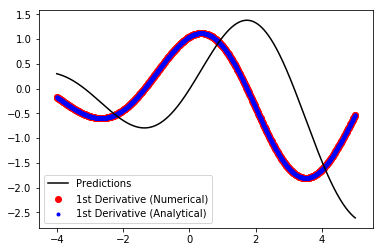

In [82]:
# Plot results
fig, ax = plt.subplots()

ax.plot(xtest, y_pred, color='black', label='Predictions')
ax.scatter(xtest, d1_numerical, color='red', marker='o', label='1st Derivative (Numerical)')
ax.scatter(xtest, d1_analytical, color='blue', marker='.', label='1st Derivative (Analytical)')


ax.legend()
plt.show()

In [ ]:
weights = gp_model.weights
signal_variance = gp_model.signal_variance
length_scale = gp_model.length_scale

d1_analytical = ard_derivative(xtrain, xtest, weights, length_scale, signal_variance)
d1_numerical = gp_model.mu_kern(xtest)

print(d1_analytical.shape, d1_numerical.shape)
np.testing.assert_array_almost_equal(d1_analytical, d1_numerical)

## 1st and 2nd Derivatives

In [26]:
mean_1der = gp_model.mu_grad(xtest)          # 1st Derivative
mean_2der = gp_model.mu_grad(xtest, nder=2)  # 2nd Derivative

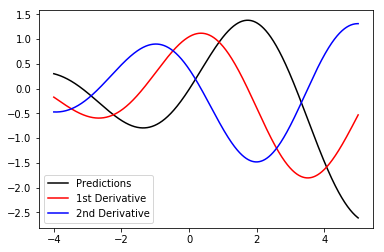

In [27]:
# Plot results
fig, ax = plt.subplots()

ax.plot(xtest, y_pred, color='black', label='Predictions')
ax.plot(xtest, mean_1der, color='red', label='1st Derivative')
ax.plot(xtest, mean_2der, color='blue', label='2nd Derivative')

ax.legend()
plt.show()

## 2d Example`

In [31]:
from sklearn.datasets import load_boston
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, WhiteKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

In [30]:
X, y = load_boston().data, load_boston().target

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=123)
print(xtrain.shape, xtest.shape)

(354, 13) (152, 13)


/Users/eman/anaconda3/envs/gp_autograd/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [32]:
%%time
kernel = C() * RBF(length_scale=[1.0] * X.shape[1]) + WhiteKernel()
gpr_model = GaussianProcessRegressor(kernel=kernel)
gpr_model.fit(xtrain, ytrain)
y_pred = gpr_model.predict(xtest);
mse = mean_squared_error(y_pred, ytest)
mae = mean_absolute_error(y_pred, ytest)
print(mse, mae)

18.5627545293 2.57367194297
CPU times: user 16.9 s, sys: 2.93 s, total: 19.8 s
Wall time: 10.2 s


In [33]:
%%time
# Initialize GP Model
gp_model = GaussianProcess()

gp_model.fit(xtrain, ytrain);

y_pred = gp_model.predict(xtest)

mse = mean_squared_error(y_pred, ytest)
mae = mean_absolute_error(y_pred, ytest)
print(mse, mae)

18.9060064115 2.59931616768
CPU times: user 1min 12s, sys: 3.18 s, total: 1min 15s
Wall time: 20.3 s


In [35]:
sk_len = gpr_model.kernel_.get_params()['k1__k2__length_scale']
my_len = gp_model.length_scale
print(sk_len)
print(my_len)

[  7.36736792e+01   1.00000000e+05   1.00000000e+05   2.76670097e+03
   4.18107140e-01   5.26296774e+00   5.68702690e+02   2.78526188e+00
   3.49362153e+02   3.94586757e+02   2.86404840e+01   2.61183205e+03
   2.24595005e+01]
[  7.12043701e+01   1.25062899e+10   5.18953556e+37   2.35755767e+04
   4.08754841e-01   5.26726748e+00   5.61543721e+02   2.75788560e+00
   1.07856542e+06   3.88696053e+02   2.66906891e+01   2.79873549e+03
   2.24143848e+01]


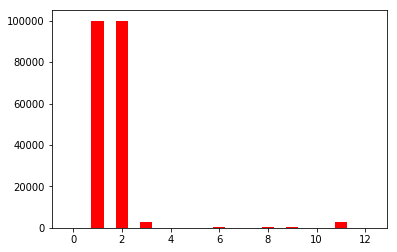

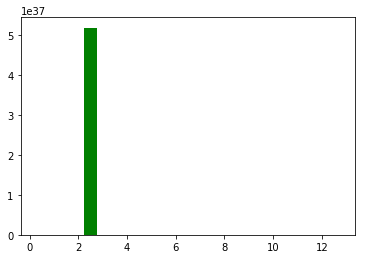

In [37]:
ind = np.arange(X.shape[1])  # the x locations for the groups
width = .5       # the width of the bars

fig, ax = plt.subplots()
gpr = ax.bar(ind, sk_len, width, color='r', label='Scikit GP')

plt.show()

fig, ax = plt.subplots()
gp = ax.bar(ind+width, my_len, width, color='g', label='Autograd GP')
plt.show()

In [40]:
der = gp_model.mu_grad(xtest)
print(der.shape)
der2 = gp_model.mu_grad(xtest, nder=2)
print(der2.shape)
derk = gp_model.mu_kern(xtest)
print(derk.shape)
derk2 = gp_model.mu_kern(xtest, nder=2)
print(derk2.shape)

(152, 13)
(152, 13)
(152, 13)
(152, 13)


In [41]:
from autograd import jacobian, hessian, hessian_vector_product

In [ ]:
length_scale = 1.0
signal_variance = 1.0


print(jac_kernel.shape)

In [42]:
%%time

# Jacobian
mu = lambda x: gp_model.rbf_covariance(xtrain, x)

jac_grad = jacobian(mu)

jac_kernel = jac_grad(xtest[:10])

CPU times: user 1.23 s, sys: 422 ms, total: 1.65 s
Wall time: 1.67 s


In [43]:
print(jac_kernel.shape)

(354, 10, 10, 13)


In [15]:
# Hessian
hess_grad = hessian(mu)

hess_kernel = hess_grad(xtest[:10])

KeyboardInterrupt: 

In [16]:
print(hess_kernel.shape)

NameError: name 'hess_kernel' is not defined

In [17]:
hessian_vec_grad = hessian_vector_product(mu)

hess_vec_kern = hessian_vec_grad(xtest[:10])
print(hess_vec_kern.shape)

IndexError: tuple index out of range

## Checking the Derivative

In [49]:
from sklearn.gaussian_process.kernels import _check_length_scale
def ard_derivative(x_train, x_test, weights, length_scale, scale, n_der=1):
    """Derivative of the GP mean function of the ARD Kernel. This function 
    computes the derivative of the mean function that has been trained with an
    ARD kernel with respect to the testing points.
    
    Parameters
    ----------
    x_train : array-like, (n_train_samples x d_dimensions)
        The training samples used to train the weights and the length scale 
        parameters.
        
    x_test : array-like, (n_test_samples x d_dimensions)
        The test samples that will be used to compute the derivative.
        
    weights : array-like, (n_train_samples, 1)
        The weights used from the training samples
        
    length_scale : array, (d_dimensions)
        The length scale for the ARD kernel. This includes a sigma value
        for each dimension.
    
    n_der : int, default: 1, ('1', '2')
        The nth derivative for the mean GP/KRR function with the ARD kernel
        
    Returns
    -------
    derivative : array-like, (n_test_samples x d_dimensions)
        The computed derivative.
        
    Information
    -----------
    Author : Juan Emmanuel Johnson
    Email  : jemanjohnson34@gmail.com
    
    References
    ----------
    Differenting GPs:
        http://mlg.eng.cam.ac.uk/mchutchon/DifferentiatingGPs.pdf
    """
    # check the sizes of x_train and x_test
    err_msg = "xtrain and xtest d dimensions are not equivalent."
    np.testing.assert_equal(x_test.shape[1], x_train.shape[1], err_msg=err_msg)
    
    n_train_samples, d_dimensions = x_train.shape
    n_test_samples = x_test.shape[0]
    length_scale = _check_length_scale(x_train, length_scale)
    
    # Make the length_scale 1 dimensional
    if np.ndim(length_scale) == 0:
        length_scale = np.array([length_scale])
    if np.ndim(weights) == 1:
        weights = weights[:, np.newaxis]

    if len(length_scale) == 1 and d_dimensions > 1:
        length_scale = length_scale * np.ones(shape=d_dimensions)
    elif len(length_scale) != d_dimensions:
        raise ValueError('Incorrect Input for length_scale.')
    
    # check the n_samples for x_train and weights are equal
    err_msg = "Number of training samples for xtrain and weights are not equal."
    np.testing.assert_equal(x_train.shape[0], weights.shape[0], err_msg=err_msg)

    if int(n_der) == 1:
        constant_term = np.diag(- np.power(length_scale**2, -1))
    
    else:
        constant_term2 = (1 / length_scale)**2
        constant_term4 = (1 / length_scale)**4
    
    # calculate the ARD Kernel
    kernel = C(scale) * RBF(length_scale)
    kernel_mat = kernel(x_test, x_train)
    
    # initialize derivative matrix
    derivative = np.zeros(shape=(n_test_samples, d_dimensions))
    if int(n_der) == 1:
        for itest in range(n_test_samples):
            
            x_tilde = (x_test[itest, :] - x_train).T
            
            kernel_term = (kernel_mat[itest, :][:, np.newaxis] * weights)

            derivative[itest, :] = constant_term.dot(x_tilde).dot(kernel_term).squeeze()
            
    else:
        for itest in range(n_test_samples):
            
            x_term = np.dot(constant_term2, np.ones(shape=(d_dimensions,
                                                          n_train_samples)))
            
            x_term += np.dot(constant_term4, (x_test[itest, :] - x_train).T**2)
            
            derivative[itest, :] = np.dot(x_term, kernel_mat[itest, :] * weights).T 
            
    return derivative


In [56]:
weights = gp_model.weights
signal_variance = gp_model.signal_variance
length_scale = gp_model.length_scale

d1_analytical = ard_derivative(xtrain, xtest, weights, length_scale, signal_variance)
d1_numerical = gp_model.mu_kern(xtest)

print(d1_analytical.shape, d1_numerical.shape)
np.testing.assert_array_almost_equal(d1_analytical, d1_numerical)

(152, 13) (152, 13)


AssertionError: 
Arrays are not almost equal to 6 decimals

(mismatch 79.40283400809716%)
 x: array([[ -1.820099e-01,  -3.692824e-17,   8.091679e-73, ...,
          2.959539e-01,   1.122459e-03,  -1.359574e+00],
       [  2.542966e-01,  -2.278740e-17,   4.380292e-72, ...,...
 y: array([[ -1.577645e+03,   3.457811e-15,  -2.537085e-70, ...,
         -2.975420e+02,   7.679814e+00,   1.723397e+03],
       [  7.340774e+01,   2.161433e-14,   4.743004e-70, ...,...